In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pickle
%env HDF5_USE_FILE_LOCKING=FALSE
    
import sys,os,json
sys.path.append(os.path.abspath('../../models/PFIN'))
sys.path.append(os.path.abspath('../../fastjet-install/lib/python3.9/site-packages'))
from dataset_pfn import PFNDataset, processed2tau
from PFIN import PFIN as Model
from torch.utils.data import DataLoader
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

env: HDF5_USE_FILE_LOCKING=FALSE


In [2]:
#Training/Testing path
preprocessed=True
dataset=''
train_path = "../../datasets/train.h5"
val_path = "../../datasets/val.h5"
test_path = "../../datasets/test.h5"

In [3]:
modelname = "../../models/PFIN/trained_models/PFIN_best_v3_sum"
model_dict = json.load(open(modelname.replace("trained_models/", "trained_model_dicts/").replace("_best", "") + ".json"))
phi_nodes = list(map(int, model_dict['phi_nodes'].split(',')))
f_nodes = list(map(int, model_dict['f_nodes'].split(',')))
n_phiI = model_dict['n_phiI']
label = model_dict['label']
Np = model_dict['Np']
x_mode = model_dict['x_mode']
augmented = model_dict['augmented']


model = Model(particle_feats = 3, 
              Phi_sizes=phi_nodes, 
              F_sizes = f_nodes,
              n_consts = Np,
              PhiI_nodes = n_phiI,
              interaction_mode = x_mode,
              augmented = augmented)
model.load_state_dict(torch.load(modelname))
model = model.cuda()
model.eval()

[100, 100, 64] [64, 100, 100]


PFIN(
  (phi): Sequential(
    (0): Sequential(
      (0): Linear(in_features=3, out_features=100, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=100, out_features=100, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=100, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (phiInt): Sequential(
    (0): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
    )
  )
  (phiInt2): Sequential(
    (0): Sequential(
      (0): Linear(in_features=67, out_features=128, bias=True)
      (1): ReLU()
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=128, bias=True)
      (1): ReLU()
    )
    (2): Sequential(
      (0): Linear(in_features=

In [4]:
F_layers = [layer for layer in model.fc[:-1]]
modelFC_ps = nn.Sequential(*F_layers)
softmax = nn.Softmax(dim=1)

In [5]:
test_set = PFNDataset(file_path = test_path, 
                      preprocessed = True,
                      n_constits = Np)
# test_data, test_mask, test_label = test_set[:]

In [6]:
def interaction_features(model, particle_feats, augmented_feats, mask):
    # expected particle_feats dim: (Nb, Np, Nx)
    # expected mask dim: (Nb, 1, Np)
    # expected augmented feats: (Nb, 7) => jet_e, jet_m, jet_pt, jet_eta, jet_phi, jet_ptsum, jet_nconst
    # return per-particle interaction embeddings with dim: (Nb, Nz, Np)
    particle_feats = torch.transpose(particle_feats, 1, 2).contiguous() # (Nb, Nx, Np)
    intR = model.tmul(particle_feats, model.Rr) # (Nb, Nx, Npp)
    intS = model.tmul(particle_feats, model.Rs) # (Nb, Nx, Npp)
    E = torch.cat([intR, intS], 1) # (Nb, 2Nx, Npp)
    #print(E[:5,:,:5])
    # Get interaction features
    E = model.get_interaction_features(E, augmented_feats, mask) # (Nb, Ni, Npp)
    #print(E.shape)
    #print(E[:5,:,:-5])
    return E # Returns interaction features

def interaction_embeddings(model, E, particle_feats, augmented_feats, mask):
    # Now applying the Interaction MLP
    particle_feats = torch.transpose(particle_feats, 1, 2).contiguous()
    E = torch.transpose(E, 1, 2).contiguous() #(Nb, Npp, Ni)
    E = model.phiInt(E.view(-1, model.Ni)) # (Nb*Npp, Nz)
    # print(E.shape)
    E = E.view(-1, model.Npp, model.Nz) # (Nb, Npp, Nz)

    if mask is not None:
        # generating masks for interactions
        mR = model.tmul(mask, model.Rr) # (Nb, 1, Npp)
        mS = model.tmul(mask, model.Rs) # (Nb, 1, Npp)
        imask = torch.transpose(mR * mS, 1, 2).contiguous() # (Nb, Npp, 1)
        E = E * imask # (Nb, Npp, Nz) with non-existent interactions masked


    # Now returning Interactions to particle level inputs
    E = torch.transpose(E, 1, 2).contiguous() # (Nb, Nz, Npp)
    E = ( model.tmul(E, torch.transpose(model.Rr, 0, 1).contiguous())  \
        + model.tmul(E, torch.transpose(model.Rs, 0, 1).contiguous()) ) / augmented_feats[:,6].reshape(-1,1,1) # (Nb, Nz, Np)


    if mask is not None:
        E = E * mask.bool().float()

    # Now concatenaing inputs with first interaction outputs
    E = torch.cat([particle_feats, E], 1) #(Nb, Nx+Nz, Np)
    E = torch.transpose(E, 1, 2).contiguous() #(Nb, Np, Nx+Nz)
    E = model.phiInt2(E.view(-1, model.Nx + model.Nz)) #(Nb*Np, Nz)
    E = E.view(-1, model.Np, model.Nz) #(Nb, Np, Nz)
    E = torch.transpose(E, 1, 2).contiguous() #(Nb, Nz, Np)

    if mask is not None:
        E = E * mask.bool().float()

    return E

In [7]:
def getTrackID(Np, mask_index):
    return torch.sum(torch.arange((Np - 1), (Np - 1) + mask_index[0]*(-1), -1)).item() + \
                               mask_index[1] - mask_index[0] - 1

def removeOutliers(x, lq = 0.25, rq = 0.75, outlierConstant=5):
    quantiles = np.nanquantile(x, (lq, rq),axis=0)
    IQR = (quantiles[1]-quantiles[0])*outlierConstant
    result = np.where((x>=quantiles[0]-IQR)&(x<=quantiles[1]+IQR), x, 0)
    
    return result

def evalLatents(model, test_set, mask_index = None):
    myDL = DataLoader(test_set, batch_size=1024)
    masked_track = None
    with torch.no_grad():
        for idx, (d, m, l, ad, _) in enumerate(myDL):
            d = d.cuda()
            m = m.cuda()
            l = l.cuda()
            ad = ad.cuda()
            #this_taus = processed2tau(d,ad)
            P = model.get_particle_embeddings(d, m)
            E = interaction_features(model, d, ad, m)
            if mask_index != None and len(mask_index) == 2 and mask_index[0] < mask_index[1]:
                masked_track = getTrackID(model.Np, mask_index)
                #torch.sum(torch.arange((model.Np - 1), (model.Np - 1) + mask_index[0]*(-1), -1)).item() + \
                #               mask_index[1] - mask_index[0] - 1
                m[:, :, mask_index] = 0 
            I = interaction_embeddings(model, E, d, ad, m)
            
            if model.x_mode == 'sum':
                L = P.sum(-1) + I.sum(-1)
            else:
                L = torch.cat([P, I], 1).sum(-1)
            this_psmax = modelFC_ps(L)
            this_preds = softmax(this_psmax)
            if idx == 0:
                latents = L.cpu()
                labels = l.cpu()
                intfeat = E.cpu()
                presoftmax = this_psmax.cpu()
                preds = this_preds.cpu()
                #aug_data = ad.cpu()
                #masked_tracks = [masked_track]
                #taus = this_taus.cpu()
            else:
                latents = torch.cat((latents, L.cpu()), 0)
                labels = torch.cat((labels, l.cpu()), 0)
                intfeat = torch.cat((intfeat, E.cpu()),0)
                presoftmax  = torch.cat((presoftmax, this_psmax.cpu()), 0)
                preds  = torch.cat((preds, this_preds.cpu()), 0)
                #aug_data = torch.cat((aug_data, ad.cpu()), 0)
                #masked_tracks.append(masked_track)
                #taus = torch.cat((taus, this_taus.cpu()), 0)
            if idx == 100:
                break
    return latents, labels, intfeat, presoftmax, preds, masked_track

In [8]:
baseline_latents, baseline_labels, baseline_intfeat, baseline_presoftmax, baseline_preds, _ = evalLatents(model, test_set)

In [9]:
auc_baseline = roc_auc_score(baseline_labels[:, 1].numpy(), baseline_preds[:, 1].numpy())*100
print("Baseline model's AUC: {:.4f}%".format(auc_baseline))

Baseline model's AUC: 98.3940%


In [10]:
bkg_indices = baseline_labels[:, 0] == 1
sig_indices = baseline_labels[:, 0] == 0

In [11]:
N2track = 10
shift_matrix = torch.zeros(N2track, N2track).numpy()
dLRP_matrix = torch.zeros(N2track, N2track).numpy()
dAUC_matrix = torch.zeros(N2track, N2track).numpy()

for i in range(N2track-1):
    for j in range(i+1, N2track):
        latents, labels, intfeat, presoftmax, preds, masked_track = evalLatents(model, test_set, mask_index=(i,j))
        auc2 = roc_auc_score(labels[:, 1].numpy(), preds[:, 1].numpy())*100
        
        dAUC_matrix[i,j] = auc_baseline - auc2
        
        dsoftmax = torch.abs((baseline_presoftmax - presoftmax)/baseline_presoftmax).numpy()
        dresult = (baseline_preds - preds).numpy()
        
        shift_matrix[i,j] = removeOutliers(dresult[sig_indices, 1]).mean()
        shift_matrix[j,i] = removeOutliers(dresult[bkg_indices, 0]).mean()
        
        dLRP_matrix[i,j] = removeOutliers(dsoftmax[sig_indices, 1]).mean()
        dLRP_matrix[j,i] = removeOutliers(dsoftmax[bkg_indices, 0]).mean()
        
        

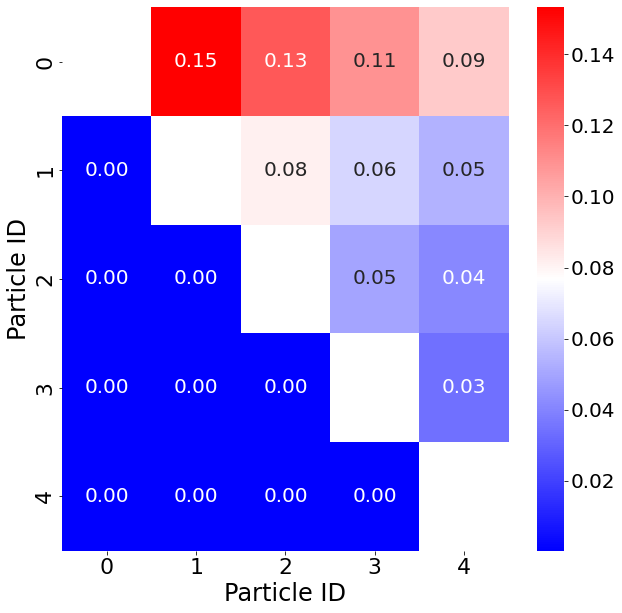

In [20]:
for i in range(N2track):
    shift_matrix[i,i] = np.nan
plt.figure(figsize=(10,10))
ax = sns.heatmap(shift_matrix[:N2track//2, :N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20})
plt.tick_params(axis='both', which='major', labelsize=22)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.xlabel('Particle ID', fontsize=24)
plt.ylabel('Particle ID', fontsize=24)
plt.savefig("figures/dpred_PFIN_{}.pdf".format(label))

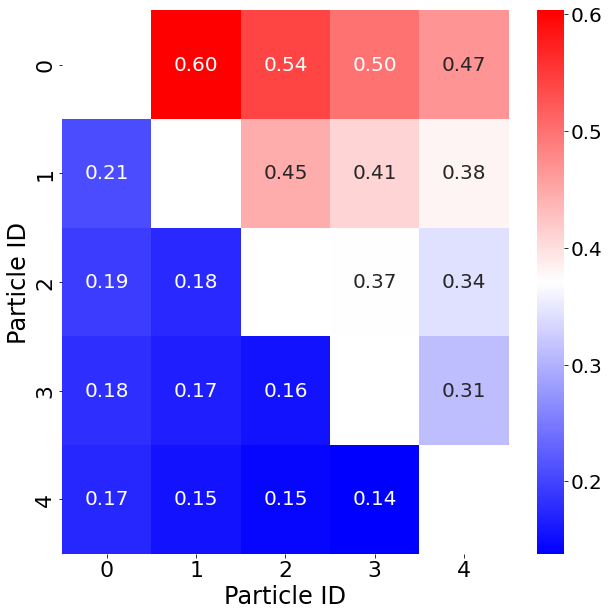

In [16]:
for i in range(N2track):
    dLRP_matrix[i,i] = np.nan
plt.figure(figsize=(10,10))
ax = sns.heatmap(dLRP_matrix[:N2track//2, :N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20})
plt.tick_params(axis='both', which='major', labelsize=22)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.xlabel('Particle ID', fontsize=24)
plt.ylabel('Particle ID', fontsize=24)
plt.savefig("figures/MAD_PFIN_{}.pdf".format(label))

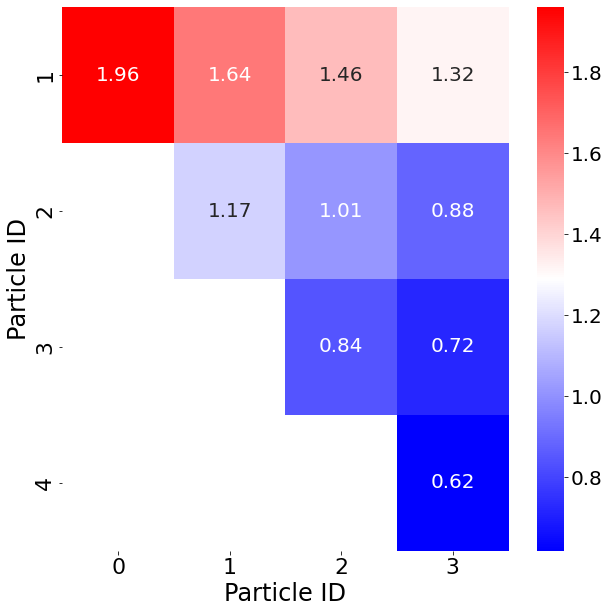

In [17]:
for i in range(N2track):
    for j in range(i+1):
        dAUC_matrix[i,j] = np.nan
plt.figure(figsize=(10,10))
xlabels = list(map(str, [i for i in range(1, N2track//2)]))
ylabels = list(map(str, [i for i in range(0, N2track//2 - 1)]))
ax = sns.heatmap(dAUC_matrix[:N2track//2-1, 1:N2track//2], annot = True, cmap='bwr', fmt='.2f', annot_kws={'size':20})
plt.yticks(np.arange(0,len(xlabels),1)+0.5, xlabels, fontsize=24)
plt.xticks(np.arange(0,len(ylabels),1)+0.5, ylabels, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=22)
plt.xlabel('Particle ID', fontsize=24)
plt.ylabel('Particle ID', fontsize=24)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=20)
plt.savefig("figures/dAUC_PFIN_{}.pdf".format(label))